<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-setup" data-toc-modified-id="Imports-and-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and setup</a></span></li><li><span><a href="#Simulating-the-required-data-set" data-toc-modified-id="Simulating-the-required-data-set-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Simulating the required data set</a></span></li><li><span><a href="#Ranking-the-columns" data-toc-modified-id="Ranking-the-columns-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Ranking the columns</a></span></li><li><span><a href="#Testing-it-out" data-toc-modified-id="Testing-it-out-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Testing it out</a></span></li></ul></div>

# Task 1 <a class="tocSkip">

### Imports and setup

In [1]:
from sklearn.datasets import make_blobs
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
from pprint import PrettyPrinter

pp = PrettyPrinter(depth = 5)

# <a class="tocSkip">

### Simulating the required data set

In [2]:
def simulate_data(N, P, S, K):
    
    """
    Simulates a dataset with clusters, including relevant and irrelevant columns.
    
    Args -> 
        N: Number of rows in the data.
        P: Total number of columns in the data.
        S: Number of columns that are relevant to the clustering.
        K: Number of clusters.
           
    Returns -> 
        data: A Pandas DataFrame according to the supplied specifications.
        
        
    Raises ->
        AssertionError: When P < S, When K < 1.  
    
    """
    assert K > 0
    assert P > S
    
    relevant_col_names = ["col_"+str(i) for i in range(S)]
    relevant_col_names.append('cluster')
    
    X, y = make_blobs(n_samples=N, n_features=S, random_state=0, centers=K)
    data = np.column_stack((X, y))
    data = pd.DataFrame(data, columns = relevant_col_names)
    
    num_synth_cols = P-S
    synth_data = pd.DataFrame()
    for i in range(num_synth_cols):
        col = np.random.random(N)
        synth_data["synth_col_"+str(i)] = col

    data = pd.concat((data, synth_data), axis=1)
    
    print("Generated {} clustered dataset with {} rows and {} columns ({} useful, {} irrelevant)".
          format(K, N, P, S, P-S))
    
    return data

# <a class="tocSkip">

### Ranking the columns

We group each column's data by its assigned cluster and perform a one-way ANOVA.

The p-value is used to determine whether the column likely contributed to the clustering or not.

Here, for each column after grouping by cluster - 

**H0** - The differences in means are statistically insignificant (the groups are likely similar, hence are unlikely to contribute to clustering)
**H1** - The differences in means are statistically significant (the groups are likely different, and hence contribute to clustering)

The significance level (alpha) is set to 0.01.

In [3]:
def rank_columns(data):
    
    """
    Assigns a score to every column of the input dataframe based on its likelihood
    on being a useful feature during clustering.
    
    Args ->
        data: A Pandas DataFrame ideally generated as an output by simulate_data()
    
    Returns ->
        column_scores: A dict() object of format {column name: (F-statistic, pvalue)}
        containing the F-statistic and p-values
        for each column.
    
    Raises ->
        AssertionError: To ensure a non-empty DataFrame.
        
    
    """
    
    assert data.shape[0] != 0
    assert data.shape[1] != 0
    
    columns = data.columns
    cluster_labels = set(data['cluster'])
    column_scores = {}
    
    for col in columns:
        if col != 'cluster':
            subsets = []
            for lab in cluster_labels:
                subsets.append(data[col][data['cluster'] == lab])
            
            # One-way ANOVA
            column_scores[col] = stats.f_oneway(*subsets)
    
    pp.pprint(column_scores)
    
    return column_scores

# <a class="tocSkip">

### Testing it out

Generated 3 clustered dataset with 1000 rows and 10 columns (5 useful, 5 irrelevant)


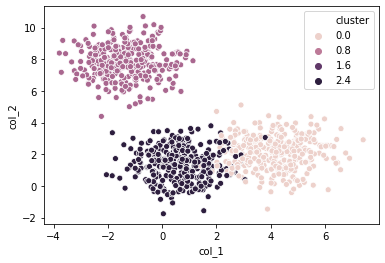

In [8]:
data = simulate_data(N = 1000, P = 10, S = 5, K = 3)
sns.scatterplot(x = data['col_1'], y = data['col_2'], hue=data['cluster']);

In [5]:
ranks = rank_columns(data)

{'col_0': F_onewayResult(statistic=2086.1533505545663, pvalue=0.0),
 'col_1': F_onewayResult(statistic=2669.146702410896, pvalue=0.0),
 'col_2': F_onewayResult(statistic=4081.4622996699377, pvalue=0.0),
 'col_3': F_onewayResult(statistic=7591.417249296611, pvalue=0.0),
 'col_4': F_onewayResult(statistic=5263.902818792181, pvalue=0.0),
 'synth_col_0': F_onewayResult(statistic=1.166745535010567, pvalue=0.31180344600817084),
 'synth_col_1': F_onewayResult(statistic=0.36798430164180335, pvalue=0.692222011785206),
 'synth_col_2': F_onewayResult(statistic=0.1041794825919943, pvalue=0.9010733653692429),
 'synth_col_3': F_onewayResult(statistic=0.43624595460424315, pvalue=0.6465820447999193),
 'synth_col_4': F_onewayResult(statistic=1.244394378750052, pvalue=0.28856244139922654)}


The first 6 columns have a p-value less than the significance level (0.01). Hence, we can reject the null hypothesis and infer that these columns likely do contribute to the clustering.

###### <a class="tocSkip">

Generated 4 clustered dataset with 1000 rows and 10 columns (3 useful, 7 irrelevant)


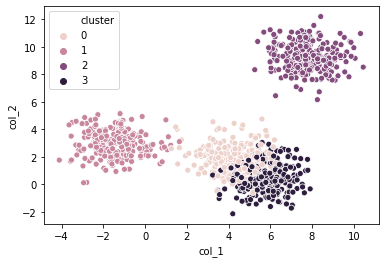

In [6]:
data = simulate_data(N = 1000, P = 10, S = 3, K = 4)
sns.scatterplot(x = data['col_1'], y = data['col_2'], hue=data['cluster']);

In [7]:
ranks = rank_columns(data)

{'col_0': F_onewayResult(statistic=739.4358674919064, pvalue=8.407495127880647e-253),
 'col_1': F_onewayResult(statistic=3984.4381680857823, pvalue=0.0),
 'col_2': F_onewayResult(statistic=4022.427788579511, pvalue=0.0),
 'synth_col_0': F_onewayResult(statistic=0.08128320287062638, pvalue=0.9702019081208703),
 'synth_col_1': F_onewayResult(statistic=0.3608171524858256, pvalue=0.7813228301569232),
 'synth_col_2': F_onewayResult(statistic=2.240515519195281, pvalue=0.08201578061794909),
 'synth_col_3': F_onewayResult(statistic=1.4445715028739736, pvalue=0.22829972507684373),
 'synth_col_4': F_onewayResult(statistic=0.28447207290840876, pvalue=0.8366373826203632),
 'synth_col_5': F_onewayResult(statistic=2.0469900588652927, pvalue=0.10567595313555639),
 'synth_col_6': F_onewayResult(statistic=1.049032854692643, pvalue=0.3699937559742942)}


We hold that columns with a p-value greater than 0.01 (above the significance threshold) form groups that are likely similar even with clustering, are thus unlikely to be contributing to the clustering. 

For these columns, the null hypothesis is rejected. 

# <a class="tocSkip">